In [ ]:
import numpy as np

In [ ]:
# author - Mathuranathan Viswanathan (gaussianwaves.com
# This code is part of the book "Digital Modulations using Python"
# https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/

from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,ms=0,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        ms: if receiving single numbers, can compute the 'mean squared' beforehand
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        n : generated awgn noise (n), or
        r : received signal vector (r=s+n)
"""

    gamma = 10**(SNRdB/10) #SNR to linear scale

    if isinstance(s, float) or isinstance(s, (int, float, str, np.number)):
        P = L*ms
    elif s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]

    N0=P/gamma # Find the noise spectral density

    if isinstance(s, float) or isinstance(s, (int, float, str, np.number)):
        n = sqrt(N0/2)*standard_normal(1)[0]
    elif isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))

    r = s + n # received signal
    return r


def bsc(c, p):
    rands = np.random.binomial(1, [p] * c.size)
    return np.mod(c + rands, 2)


In [ ]:
def ber(c, est):
  return np.sum(np.mod(c + est, 2)) / len(c)

In [ ]:
from typing import Any, Callable
import itertools
import matplotlib.pyplot as plt

In [ ]:
def bsc_llr(p: float) -> Callable:
    """
    bsc llr is defined as:
        L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) = (-1)^y log((1-p)/p)
    :param float p: the llr is parameterized by the bit flip probability of the channel p.
    :returns: return a callable which accepts a single argument - y_i (a bit from the channel), and returns its llr
    """
    return lambda y: np.power(-1, y) * np.log((1-p)/p)

def awgn_llr(snrDB=1, m=0) -> Callable:
    """
    awgn llr is defined as:
      L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) =
      log \left( \frac{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( \frac{ e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} \right) - log \left(  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} \right) =
      - \frac{(0 - \mu)^2}{2 \sigma^2} + \frac{(1 - \mu)^2}{2 \sigma^2} =
      \frac{\mu^2 - 2\mu + 1 - \mu^2}{2 \sigma^2} =
      \frac{1 - 2 \mu}{2 \sigma^2}

    """
    gamma = 10**(snrDB/10)
    # snr = 10 log(signal_variance / noise_variance)
    # signal_variance = 10**(snr/10) * noise_variance = gamma * noise_variance
    return lambda y: np.power(-1, np.round_(y)) * (1 - 2 * m) * gamma / 2


In [ ]:
from functools import total_ordering
from abc import ABC, abstractmethod

class Node:
  None

@total_ordering
class Node(ABC):
    """Base class VNodes anc CNodes.
    Derived classes are expected to implement an "initialize" and  method a "message" which should return the message to
    be passed on the graph.
    Nodes are ordered and deemed equal according to their ordering_key.
    """
    _uid_generator = itertools.count()

    def __init__(self, name: str = "", ordering_key: int = None) -> None:
        """
        :param name: name of node
        """
        self.uid = next(Node._uid_generator)
        self.name = name if name else str(self.uid)
        self.ordering_key = ordering_key if ordering_key is not None else str(self.uid)
        self.neighbors: dict[int, Node] = {}  # keys as senders uid
        self.received_messages: dict[int, Any] = {}  # keys as senders uid, values as messages

    def register_neighbor(self, neighbor: Node) -> None:
        self.neighbors[neighbor.uid] = neighbor

    def __str__(self) -> str:
        if self.name:
            return self.name
        else:
            return str(self.uid)

    def get_neighbors(self) -> list[int]:
        return list(self.neighbors.keys())

    def receive_messages(self) -> None:
        for node_id, node in self.neighbors.items():
            self.received_messages[node_id] = node.message(self.uid)

    @abstractmethod
    def message(self, requester_uid: int) -> Any:
        pass

    @abstractmethod
    def initialize(self):
        pass

    def __hash__(self):
        return self.uid

    def __eq__(self, other):
        if not isinstance(other, Node):
            return NotImplemented
        return self.ordering_key == other.ordering_key

    def __lt__(self, other):
        if not isinstance(other, Node):
            return NotImplemented
        return self.ordering_key < other.ordering_key


class CNode(Node):

    def initialize(self):
        self.received_messages = {node_uid: 0 for node_uid in self.neighbors}

    def message(self, requester_uid: int) -> np.float_:
        def phi(x):
            return -np.log(np.tanh(x/2))
        q = np.array([msg for uid, msg in self.received_messages.items() if uid != requester_uid])
        return np.prod(np.sign(q))*phi(np.sum(phi(np.absolute(q))))


class VNode(Node):
    def __init__(self, channel_model: Callable, ordering_key: int, name: str = ""):
        """
        :param channel_model: a function which receives channel outputs anr returns relevant message
        :param ordering_key: used to order nodes per their order in the parity check matrix
        :param name: optional name of node
        """
        self.channel_model = channel_model
        self.channel_symbol: int = None  # currently assuming hard channel symbols
        self.channel_llr: np.float_ = None
        super().__init__(name, ordering_key)

    def initialize(self, channel_symbol):
        self.channel_symbol = channel_symbol
        self.channel_llr = self.channel_model(channel_symbol)
        self.received_messages = {node_uid: 0 for node_uid in self.neighbors}

    def message(self, requester_uid: int) -> np.float_:
        return self.channel_llr + np.sum(
            [msg for uid, msg in self.received_messages.items() if uid != requester_uid]
        )

    def estimate(self) -> np.float_:
        return self.channel_llr + np.sum(list(self.received_messages.values()))


In [ ]:
import networkx as nx
import numpy.typing as npt

class TannerGraph:
  None

class TannerGraph:
    def __init__(self):
        self.v_nodes: dict[int, VNode] = {}
        self.c_nodes: dict[int, CNode] = {}
        self.edges = set()

    def add_v_node(self, channel_model: Callable, ordering_key: int, name: str = "") -> VNode:
        """
        :param ordering_key: should reflect order according to parity check matrix, channel symbols in order
        :param name: name of node.
        :param channel_model: add an exiting node to graph. If not used a new node is created.
        """
        node = VNode(channel_model, ordering_key, name)
        self.v_nodes[node.uid] = node
        return node

    def add_c_node(self, name: str = "", ordering_key: int = None) -> CNode:
        """
        :param ordering_key: use only for debug purposes
        :param name: name of node
        """
        node = CNode(name, ordering_key)
        self.c_nodes[node.uid] = node
        return node

    def add_edge(self, vnode_uid: int, cnode_uid: int) -> None:
        if vnode_uid not in self.v_nodes:
            raise ValueError()
        if cnode_uid not in self.c_nodes:
            raise ValueError()
        self.c_nodes.get(cnode_uid).register_neighbor(self.v_nodes.get(vnode_uid))
        self.v_nodes.get(vnode_uid).register_neighbor(self.c_nodes.get(cnode_uid))
        self.edges.update({(vnode_uid, cnode_uid)})

    def add_edges_by_uid(self, edges_set: set[tuple[int, int]]) -> None:
        """
        :param edges_set: each element in the set is a tuple. In the tuple first element is a v-node uid and second is
        c-node uid
        """
        for v_uid, c_uid in edges_set:
            if v_uid not in self.v_nodes:
                raise ValueError("No v-node with uid " + str(v_uid) + " in graph")
            if c_uid not in self.c_nodes:
                raise ValueError("No c-node with uid " + str(c_uid) + " in graph")
            self.add_edge(v_uid, c_uid)

    def add_edges_by_name(self, edges_set: set[tuple[str, str]]) -> None:
        """
        :param edges_set: each element in the set is a tuple. In the tuple first element is a v-node name and second is
        c-node name
        """
        for v_name, c_name in edges_set:
            v_uid = [node.uid for node in self.v_nodes.values() if node.name == v_name]
            if not v_uid:
                raise ValueError("No v-node with name " + v_name + " in graph")
            c_uid = [node.uid for node in self.c_nodes.values() if node.name == c_name]
            if not c_uid:
                raise ValueError("No c-node with name " + c_name + " in graph")
            self.add_edge(v_uid[0], c_uid[0])

    def get_edges(self, by_name=False) -> set:
        """
        :param by_name: if true nodes are referred to by name, otherwise by uid. Default to false
        :return: returns a set of edges. if by_name each element is a tuple of node names, else it is a tuple of uid's.
        """
        if not by_name:
            return self.edges
        return {(self.v_nodes.get(vnode).name, self.c_nodes.get(cnode).name) for vnode, cnode in self.edges}

    def to_nx(self) -> nx.Graph:
        g = nx.Graph()
        for uid, node in self.c_nodes.items():
            g.add_node(uid, label=node.name, bipartite=0, color="#bbb")
        for uid, node in self.v_nodes.items():
            g.add_node(uid, label=node.name, bipartite=1, color="#bbb")
        g.add_edges_from(self.edges)
        return g

    @classmethod
    def from_biadjacency_matrix(cls, h: npt.ArrayLike, channel_model: Callable) -> TannerGraph:
        """
        :param channel_model: channel model to compute channel symbols llr within v nodes
        :param h: parity check matrix, shape MXN with M check nodes and N variable nodes. assumed binary matrix.
        """
        g = TannerGraph()
        h = np.array(h)
        m, n = h.shape
        for i in range(n):
            g.add_v_node(name="v" + str(i), channel_model=channel_model, ordering_key=i)
        for j in range(m):
            g.add_c_node(name="c" + str(j), ordering_key=j)
            for i in range(n):
                if h[j, i] == 1:
                    g.add_edges_by_name({("v" + str(i), "c" + str(j))})
        return g

    def __str__(self) -> str:
        return "Graph with " + str(len(self.c_nodes) + len(self.v_nodes)) + " nodes and " + str(len(self.edges)) + \
               " edges"

    def ordered_v_nodes(self) -> list[VNode]:
        return sorted(self.v_nodes.values())

In [ ]:
from numpy.typing import ArrayLike, NDArray
import numpy as np


class BeliefPropagation:
    def __init__(self, graph: TannerGraph, h: ArrayLike, max_iter: int):
        self.h = np.array(h)
        self.graph = graph
        self.n = len(graph.v_nodes)
        self.max_iter = max_iter

    def simulate(self, channel_word):
        if len(channel_word) != self.n:
            raise ValueError("incorrect block size")

        # initial step
        for idx, node in enumerate(self.graph.ordered_v_nodes()):
            node.initialize(channel_word[idx])

    def decode(self) -> tuple[NDArray, NDArray, bool]:
        for node in self.graph.c_nodes.values():  # send initial channel based messages to check nodes
            node.receive_messages()

        for _ in range(self.max_iter):
            # Check to Variable Node Step(horizontal step):
            for node in self.graph.v_nodes.values():
                node.receive_messages()
            # Variable to Check Node Step(vertical step)
            for node in self.graph.c_nodes.values():
                node.receive_messages()

            # Check stop condition
            llr = np.array([node.estimate() for node in self.graph.ordered_v_nodes()])
            estimate = np.array([1 if node_llr < 0 else 0 for node_llr in llr])
            # print(f"--llr: {llr}")
            # print(f"--mid_estimate: {estimate}")
            syndrome = self.h.dot(estimate) % 2
            if not syndrome.any():
                break

        return estimate, llr, not syndrome.any()


code: [1 0 1 1 1 0 0]
unest: [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, -0.0]
res: [ 1.  0.  1.  1.  1.  0. -0.] 
    parity check: [0. 0. 0.] 
    ber: 0.0
resbp: [0 1 0 0 0 1 1] 
    parity check: [0 0 0] 
    ber: 1.0


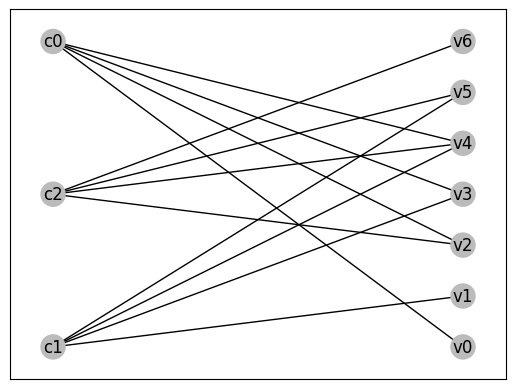

In [ ]:
# EXAMPLE BP EXECUTION

# H = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
#               [1, 0, 0, 0, 1, 1, 1, 0, 0, 0],
#               [0, 1, 0, 0, 1, 0, 0, 1, 1, 0],
#               [0, 0, 1, 0, 0, 1, 0, 1, 0, 1],
#               [0, 0, 0, 1, 0, 0, 1, 0, 1, 1]])
# true_c = np.array([0,0,0,0,0,0,0,0,0,0])
# c = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

H = np.array([
  [1, 0, 1, 1, 1, 0, 0],
  [0, 1, 0, 1, 1, 1, 0],
  [0, 0, 1, 0, 1, 1, 1],
])
true_c = np.array([1, 0, 1, 1, 1, 0, 0])
c = np.array([1, 0, 1, 1, 1, 0, 1])


# C(65,36)
# h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
# h_raw = h_raw.split(";")
# H = []
# for idx, h_raw_row in enumerate(h_raw):
#   if (h_raw_row == ""): break
#   mid = h_raw_row.strip()
#   mid = mid.split(" ")
#   H.append([float(i) for i in mid])
# H = np.array(H)
# c = true_c = (H[0]) % 2

is_channel_bsc = False

if is_channel_bsc:
  # Assume a BSC channel model with probability p=0.1 for bit flip
  c = bsc(true_c, 0.1)
  model = bsc_llr(0.1)
else:
  snrDB = 6
  # Assume an AWGN channel with given SNR
  c = awgn(true_c, snrDB)
  c = np.round_(c)
  model = awgn_llr(snrDB, np.sum(c)/c.size)

print(f"code: {true_c}")

tg = TannerGraph.from_biadjacency_matrix(H, channel_model=model)
bp = BeliefPropagation(tg, H, max_iter=5)
bp.simulate(c)

# check initial results
if is_channel_bsc:
  unestimated = c
else:
  tg_vnodes = tg.ordered_v_nodes()
  # unestimated = [v.channel_symbol for v in tg_vnodes]
  # print(f"symb: {unestimated}")
  # unestimated = [v.channel_llr for v in tg_vnodes]
  # print(f"llr: {unestimated}")
  unestimated = [v.channel_symbol for v in tg_vnodes]
  print(f"unest: {unestimated}")
  unestimated = np.round(unestimated)

check_res = H.dot(unestimated) % 2
ber_res = ber(true_c, unestimated)
print(f"res: {unestimated} \n    parity check: {check_res} \n    ber: {ber_res}")

# let us try to correct the error
estimate, llr, decode_success = bp.decode()
# You can see that the error is corrected
check_resbp = H.dot(estimate) % 2
ber_resbp = ber(true_c, estimate)
print(f"resbp: {estimate} \n    parity check: {check_resbp} \n    ber: {ber_resbp}")

g = tg.to_nx()

fig = plt.figure()
top = nx.bipartite.sets(g)[0]
labels = {node: d["label"] for node, d in g.nodes(data=True)}
nx.draw_networkx(g,
                 with_labels=True,
                 node_color=[d["color"] for d in g.nodes.values()],
                 pos=nx.bipartite_layout(g, top),
                 labels=labels)
fig.show()


In [ ]:
# ACTUAL RUNNER
class Runner:
  H = []
  cw_count = 0
  MAX_CODEWORDS = 20
  codewords = []

  def __init__(self, pcm):
    self.H = pcm
    self.h_len = pcm.shape[0]

  def create_codewords(self):
    for i in range(self.h_len):
      self.cw_recurse(i+1, H[i])

  def cw_recurse(self, l, add):
    if self.cw_count >= self.MAX_CODEWORDS: return
    self.codewords.append(add)
    self.cw_count += 1
    for j in range(l, self.h_len):
      next = (add + H[j]) % 2
      self.cw_recurse(j+1, next)

  def run_experiments_bsc(self):
    # do experiments
    ber_for_bsc = {}

    for p in [0.1,0.2,0.3]:
      total_ber = 0
      for cw in self.codewords:
        true_c = cw
        # assume bsc channel with given p
        c = bsc(true_c, p)
        model = bsc_llr(p)

        tg = TannerGraph.from_biadjacency_matrix(H, channel_model=model)
        bp = BeliefPropagation(tg, H, max_iter=5)
        bp.simulate(c)

        # tg_vnodes = tg.ordered_v_nodes()
        # unestimated = [v.channel_symbol for v in tg_vnodes]
        # print(f"unest: {unestimated}")
        # unestimated = np.round(unestimated)

        # check_res = H.dot(unestimated) % 2
        # ber_res = ber(true_c, unestimated)
        # print(f"res: {unestimated} \n    parity check: {check_res} \n    ber: {ber_res}")

        estimate, llr, decode_success = bp.decode()
        check_resbp = H.dot(estimate) % 2
        ber_resbp = ber(true_c, estimate)
        # print(f"code: {true_c} \n    resbp: {estimate} \n    parity check: {check_resbp} \n    ber: {ber_resbp}")
        total_ber += ber_resbp

      total_ber /= len(self.codewords)
      ber_for_bsc[p] = total_ber

    print(ber_for_bsc)

  def run_experiments_awgn(self):
    # do experiments
    ber_for_snr = {}

    # for snr in [1, 2, 3, 4, 5, 6]:
    for snr in [1,3,6]:
      total_ber = 0
      for cw in self.codewords:
        true_c = cw
        # Assume an AWGN channel with given SNR
        c = awgn(true_c, snrDB)
        c = np.round_(c)
        model = awgn_llr(snrDB, np.sum(c)/c.size)

        tg = TannerGraph.from_biadjacency_matrix(H, channel_model=model)
        bp = BeliefPropagation(tg, H, max_iter=5)
        bp.simulate(c)

        # tg_vnodes = tg.ordered_v_nodes()
        # unestimated = [v.channel_symbol for v in tg_vnodes]
        # print(f"unest: {unestimated}")
        # unestimated = np.round(unestimated)

        # check_res = H.dot(unestimated) % 2
        # ber_res = ber(true_c, unestimated)
        # print(f"res: {unestimated} \n    parity check: {check_res} \n    ber: {ber_res}")

        estimate, llr, decode_success = bp.decode()
        check_resbp = H.dot(estimate) % 2
        ber_resbp = ber(true_c, estimate)
        # print(f"code: {true_c} \n    resbp: {estimate} \n    parity check: {check_resbp} \n    ber: {ber_resbp}")
        total_ber += ber_resbp

      total_ber /= len(self.codewords)
      ber_for_snr[snr] = total_ber

    print(ber_for_snr)

# C(65,36)
h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
h_raw = h_raw.split(";")
H = []

for idx, h_raw_row in enumerate(h_raw):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H.append([float(i) for i in mid])
H = np.array(H)

main = Runner(H)
main.create_codewords()
# print(main.codewords)
main.run_experiments_awgn()
main.run_experiments_bsc()


{1: 0.20793650793650792, 3: 0.2103174603174603, 6: 0.12380952380952381}
{0.1: 0.09682539682539684, 0.2: 0.18412698412698414, 0.3: 0.30634920634920637}


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class BPModel(nn.Module):
   def __init__(self,
              pcm,
              L=5,
              channel_model=lambda y:y):
        super(BPModel, self).__init__()

        self.channel_model = channel_model

        # count and form edges
        self.E = np.count_nonzero(pcm)
        self.edges_to_vc = [] # E-length array of the index of "v" and "c" associated with the edge, for LLR
        for i_c, pcm_c in enumerate(pcm):
          for i_v, pcm_cv in enumerate(pcm_c):
            if pcm_cv == 1:
              self.edges_to_vc.append((i_v, i_c))

        # initialize parameters
        self.W_llr = nn.Parameter(torch.randn((L+1, self.E))*1e-2)
        self.W_e = nn.Parameter(torch.randn((L+1, self.E))*1e-2)
        self.L = L

        # initialize zeros
        self.x_v = torch.zeros(L+1, self.E)
        self.x_c = torch.zeros(L+1, self.E)

   def initialize(self, codeword):
        # get number of bits in codeword
        self.N = codeword.size

        # calculate llr values for each bit in codeword
        self.llr_v = [] # N-length array of calculated LLR values
        for v in codeword:
          llr = self.channel_model(v)
          self.llr_v.append(llr)
        self.llr_v = np.array(self.llr_v)
    
   def v_to_c(self, layer_num, edge_num):
        llr = self.llr_v[self.edges_to_vc[edge_num][0]]
        curr_v, _ = self.edges_to_vc[edge_num]

        x = llr + np.sum(
            [msg for idx, msg in enumerate(self.x_c[layer_num]) if curr_v == self.edges_to_vc[idx][0] and idx != edge_num]
        )
        self.x_v[layer_num+1][edge_num] = x
        # print(f"v_to_c (layer {layer_num}, edge: {edge_num}): {x}")
        return x
    
   def c_to_v(self, layer_num, edge_num):
        def phi(x):
          return -np.log(np.tanh(x/2))

        _, curr_c = self.edges_to_vc[edge_num]
  
        x = np.array([msg for idx, msg in enumerate(self.x_v[layer_num]) if curr_c == self.edges_to_vc[idx][1] and idx != edge_num])
        x = np.prod(np.sign(x))*phi(np.sum(phi(np.absolute(x))))
        self.x_c[layer_num+1][edge_num] = x
        # print(f"c_to_v (layer {layer_num}, edge: {edge_num}): {x}")
        return x
    
   def estimate(self, layer):
      v_sums = []
      for v in range(self.N):
        received_messages = [x for en, x in enumerate(self.x_c[layer]) if self.edges_to_vc[en][0] == v]
        v_sums.append(np.sum(received_messages))

      llr = self.llr_v + v_sums
      bin_est = np.array([1 if node_llr < 0 else 0 for node_llr in llr])
      return bin_est
        
   def forward(self):
        for ln in range(self.L):
          for en in range(self.E):
            self.v_to_c(ln, en)
            self.c_to_v(ln, en)
        
        # return self.x_c, self.x_v

        # compute output
        o = self.estimate(self.L)
        return o


In [ ]:
bp = BPModel(H, L=5, channel_model=model)

In [ ]:
# C(65,36)
h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
h_raw = h_raw.split(";")
H = []

for idx, h_raw_row in enumerate(h_raw):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H.append([float(i) for i in mid])
H = np.array(H)
true_c = H[0]

snrDB = 1
model = awgn_llr(snrDB, np.sum(c)/c.size)
c = awgn(true_c, snrDB)

bp.initialize(c)
est_nobp = np.array([0 if node_llr < 0.5 else 1 for node_llr in c])
estimate = bp.forward()
# estimate = bp.estimate(1)
print(f"cw: {true_c}")
print(f"cw+n: {c}")

print(f"est_nobp: {est_nobp}")
print(f"est: {estimate}")

res_ber_nobp = ber(true_c, est_nobp)
res_ber = ber(true_c, estimate)
print(f"ber_nobp: {res_ber_nobp}")
print(f"ber: {res_ber}")

<ipython-input-17-4df224370a54>:51: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.tanh(x/2))


cw: [1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
cw+n: [ 8.69902762e-01  2.14323567e-02 -3.29659221e-01 -2.37706681e-01
  5.90906808e-02  7.69551980e-01  8.02182665e-01 -6.37556424e-02
  6.72342420e-01  1.18250229e+00 -5.28116190e-01 -5.20220293e-01
 -1.36709999e-02 -9.00781794e-01  8.72851567e-02  7.43144497e-01
  1.21229532e-01  1.07789447e+00  1.07424429e+00  1.81775266e-01
 -3.83851652e-02 -4.48556455e-01  1.25617865e+00 -1.33877454e-01
  1.46007893e+00  9.65195608e-01  8.40709594e-01 -1.35540378e-03
 -5.92173032e-01  1.47307990e+00 -8.68118841e-02  8.79328377e-01
 -3.89067359e-01  1.12546226e+00  1.04672112e+00  1.10479964e+00
  1.59841521e+00  2.84458702e-01  8.95022885e-02  6.40620555e-01
 -1.59594724e-02 -1.97789142e-02  8.34594577e-03  2.14118160e-01
 -2.29617128e-01  3.64685720e-01 -4.55335737e-01  1.40029060e-01
  2.58306340e-01 

In [ ]:
import torch
def bsc_llr(p: float) -> Callable:
    """
    bsc llr is defined as:
        L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) = (-1)^y log((1-p)/p)
    :param float p: the llr is parameterized by the bit flip probability of the channel p.
    :returns: return a callable which accepts a single argument - y_i (a bit from the channel), and returns its llr
    """
    return lambda y: torch.pow(-1, y) * torch.log((1-p)/p)

def awgn_llr(snrDB=1, m=0) -> Callable:
    """
    awgn llr is defined as:
      L(c_i) = log(Pr(c_i=0| y_i) / Pr(c_i=1| y_i)) =
      log \left( \frac{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( \frac{ e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} }{  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} } \right) =
      log \left( e^{- \frac{(0 - \mu)^2}{2 \sigma^2}} \right) - log \left(  e^{- \frac{(1 - \mu)^2}{2 \sigma^2}} \right) =
      - \frac{(0 - \mu)^2}{2 \sigma^2} + \frac{(1 - \mu)^2}{2 \sigma^2} =
      \frac{\mu^2 - 2\mu + 1 - \mu^2}{2 \sigma^2} =
      \frac{1 - 2 \mu}{2 \sigma^2}

    """
    gamma = 10**(snrDB/10)
    # snr = 10 log(signal_variance / noise_variance)
    # signal_variance = 10**(snr/10) * noise_variance = gamma * noise_variance
    return lambda y: torch.pow(-1, torch.round(y)) * (1 - 2 * m) * gamma / 2


In [ ]:
# BP WITH WEIGHTS
# Inspiration from RBM:
# https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

class BPModel(nn.Module):
   def __init__(self,
              pcm,
              L=5):
        super(BPModel, self).__init__()

        # count and form edges
        self.E = torch.count_nonzero(pcm)
        self.edges_to_vc = [] # E-length array of the index of "v" and "c" associated with the edge, for LLR
        for i_c, pcm_c in enumerate(pcm):
          for i_v, pcm_cv in enumerate(pcm_c):
            if pcm_cv == 1:
              self.edges_to_vc.append((i_v, i_c))

        # initialize parameters
        self.W_e = nn.Parameter(torch.randn(L+1, self.E)*1e-2)
        self.L = L

        # initialize zeros
        self.x_v = torch.zeros(L+1, self.E)
        self.x_c = torch.zeros(L+1, self.E)

   def initialize(self, codeword, channel_model=lambda y:y):
        self.channel_model = channel_model

        # get number of bits in codeword
        self.N = codeword.size(dim=0)

        # initialize parameters
        self.W_llr = nn.Parameter(torch.randn(self.L+1, self.N)*1e-2)

        # calculate llr values for each bit in codeword
        self.llr_v = [] # N-length array of calculated LLR values
        for v in codeword:
          llr = self.channel_model(v)
          self.llr_v.append(llr)
        self.llr_v = torch.stack(self.llr_v)
    
   def v_to_c(self, layer_num, edge_num):
        llr = self.llr_v[self.edges_to_vc[edge_num][0]]
        curr_v, _ = self.edges_to_vc[edge_num]

        incoming_messages = torch.stack([msg for idx, msg in enumerate(self.x_c[layer_num]) if curr_v == self.edges_to_vc[idx][0] and idx != edge_num])
        x = llr * self.W_llr[layer_num][curr_v] + torch.sum([msg * self.W_e[layer_num][edge_num] for msg in incoming_messages])
        self.x_v[layer_num+1][edge_num] = x
        # print(f"v_to_c (layer {layer_num}, edge: {edge_num}): {x}")
        return x
    
   def c_to_v(self, layer_num, edge_num):
        def phi(x):
          return -np.log(np.tanh(x/2))

        _, curr_c = self.edges_to_vc[edge_num]
  
        x = torch.stack([msg for idx, msg in enumerate(self.x_v[layer_num]) if curr_c == self.edges_to_vc[idx][1] and idx != edge_num])
        x = torch.prod(np.sign(x))*phi(torch.sum(phi(np.absolute(x))))
        self.x_c[layer_num+1][edge_num] = x
        # print(f"c_to_v (layer {layer_num}, edge: {edge_num}): {x}")
        return x
    
   def estimate(self, layer):
      v_sums = []
      for v in range(self.N):
        received_messages = torch.stack([x for en, x in enumerate(self.x_c[layer]) if self.edges_to_vc[en][0] == v])
        weights = torch.stack([w for ew, w in enumerate(self.W_e[layer]) if self.edges_to_vc[ew][0] == v])
        v_sums.append(torch.sum(received_messages * weights))

      llr = (self.llr_v * self.W_llr[layer]) + v_sums
      # bin_est = np.array([1 if node_llr < 0 else 0 for node_llr in llr])
      bin_est = nn.Sigmoid()(llr)
      return bin_est
        
   def forward(self):
        for ln in range(self.L):
          for en in range(self.E):
            self.v_to_c(ln, en)
            self.c_to_v(ln, en)
        
        # return self.x_c, self.x_v

        # compute output
        o = self.estimate(self.L)
        return o


In [ ]:
bp = BPModel(H, L=5)

In [ ]:
# C(65,36)
h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
h_raw = h_raw.split(";")
H = []

for idx, h_raw_row in enumerate(h_raw):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H.append([float(i) for i in mid])
H = np.array(H)
true_c = H[0]

snrDB = 1
c = awgn(true_c, snrDB)
model = awgn_llr(snrDB, np.sum(c)/c.size)

c = torch.Tensor(c)

bp.initialize(c, channel_model=model)
est_nobp = np.array([0 if node_llr < 0.5 else 1 for node_llr in c])
estimate = bp.forward()
# estimate = bp.estimate(1)
print(f"cw: {true_c}")
print(f"cw+n: {c}")

print(f"est_nobp: {est_nobp}")
print(f"est: {estimate}")

res_ber_nobp = ber(true_c, est_nobp)
res_ber = ber(true_c, estimate)
print(f"ber_nobp: {res_ber_nobp}")
print(f"ber: {res_ber}")

RuntimeError: ignored

In [ ]:
a = torch.normal(0, 1, size=(1, 4))
print(a)

TypeError: ignored

# SEPARATOR
Everything after this is used for the final notebook

In [ ]:
# C(65,36)
h_raw = "1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0; 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1;"
h_raw = h_raw.split(";")
H = []

for idx, h_raw_row in enumerate(h_raw):
  if (h_raw_row == ""): break
  mid = h_raw_row.strip()
  mid = mid.split(" ")
  H.append([float(i) for i in mid])
H = torch.Tensor(H)
true_c = H[0]

snrDB = 1
c = awgn(true_c, snrDB)
ave = torch.sum(c)/c.size(dim=0)
model = awgn_llr(snrDB, ave)

c = torch.Tensor(c)

bp = BPModel(H, L=5)

bp.initialize(c, channel_model=model)
est_nobp = torch.Tensor([0 if node_llr < 0.5 else 1 for node_llr in c])

estimate = bp.forward()
# estimate = bp.estimate(1)
print(f"cw: {true_c}")
print(f"cw+n: {c}")

print(f"est_nobp: {est_nobp}")
print(f"est_wibp: {estimate}")

res_ber_nobp = ber(true_c, est_nobp)
res_ber = ber(true_c, estimate)
print(f"ber_nobp: {res_ber_nobp}")
print(f"ber_wibp: {res_ber}")

In [ ]:
# Belief Propagation Model
class BPModel(nn.Module):
  def __init__(self,
            pcm,
            L=5):

    super(BPModel, self).__init__()

    self.L = L

    # count and form edges
    self.E = torch.count_nonzero(pcm)
    self.edges_to_vc = [] # E-length array of the index of "v" and "c" associated with the edge, for LLR
    for i_c, pcm_c in enumerate(pcm):
      for i_v, pcm_cv in enumerate(pcm_c):
        if pcm_cv == 1:
          self.edges_to_vc.append((i_v, i_c))

    # initialize parameters
    self.W_e = nn.Parameter(torch.randn(L+1, self.E, requires_grad=True)*1e-2)

    # initialize zeros
    self.x_v = torch.zeros(L+1, self.E)
    self.x_c = torch.zeros(L+1, self.E)

  def initialize(self, codeword, channel_model=lambda y:y):
    """
    initializes a codeword for processing
    """
    self.channel_model = channel_model

    # get number of bits in codeword
    self.N = codeword.size(dim=0)

    # initialize parameters
    self.W_llr = nn.Parameter(torch.randn(self.L+1, self.N, requires_grad=True)*1e-2)

    # calculate llr values for each bit in codeword
    self.llr_v = [] # N-length array of calculated LLR values
    for v in codeword:
      llr = self.channel_model(v)
      self.llr_v.append(llr)
    self.llr_v = torch.stack(self.llr_v)

  def v_to_c(self, layer_num, edge_num):
    """
    computes outgoing messages from a "variable" node
    """
    llr = self.llr_v[self.edges_to_vc[edge_num][0]]
    curr_v, _ = self.edges_to_vc[edge_num]

    incoming_messages = torch.Tensor([msg for idx, msg in enumerate(self.x_c[layer_num]) if curr_v == self.edges_to_vc[idx][0] and idx != edge_num])
    x = llr * self.W_llr[layer_num][curr_v] + torch.sum(torch.Tensor([msg * self.W_e[layer_num][edge_num] for msg in incoming_messages]))
    self.x_v[layer_num+1][edge_num] = x
    # print(f"v_to_c (layer {layer_num}, edge: {edge_num}): {x}")
    return x

  def c_to_v(self, layer_num, edge_num):
    """
    computes outgoing messages from a "check" node
    """
    def phi(x):
      return -torch.log(torch.tanh(x/2))

    _, curr_c = self.edges_to_vc[edge_num]

    incoming_messages = torch.Tensor([msg for idx, msg in enumerate(self.x_v[layer_num]) if curr_c == self.edges_to_vc[idx][1] and idx != edge_num])
    x = torch.prod(torch.sign(incoming_messages))*phi(torch.sum(phi(torch.absolute(incoming_messages))))
    self.x_c[layer_num+1][edge_num] = x
    # print(f"c_to_v (layer {layer_num}, edge: {edge_num}): {x}")
    return x

  def estimate(self, layer):
    """
    computes estimation based on llr value
    """
    v_sums = []
    for v in range(self.N):
      received_messages = torch.Tensor([x for en, x in enumerate(self.x_c[layer]) if self.edges_to_vc[en][0] == v])
      v_sums.append(torch.sum(received_messages))
    v_sums = torch.stack(v_sums)

    llr = self.llr_v + v_sums
    # llr = nn.Sigmoid()(llr)
    bin_est = torch.Tensor([1 if node_llr < 0 else 0 for node_llr in llr])
    return bin_est
      
  def forward(self):
    """
    feed forward network
    """
    # run network
    for ln in range(self.L):
      for en in range(self.E):
        self.v_to_c(ln, en)
        self.c_to_v(ln, en)

    # compute output
    o = self.estimate(self.L)
    return o


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!cat /proc/meminfo

MemTotal:       13297192 kB
MemFree:         8385720 kB
MemAvailable:   11679660 kB
Buffers:          329616 kB
Cached:          3125444 kB
SwapCached:            0 kB
Active:           633800 kB
Inactive:        4045524 kB
Active(anon):       1156 kB
Inactive(anon):  1203884 kB
Active(file):     632644 kB
Inactive(file):  2841640 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               180 kB
Writeback:             0 kB
AnonPages:       1224396 kB
Mapped:           412096 kB
Shmem:              1520 kB
KReclaimable:     122212 kB
Slab:             152656 kB
SReclaimable:     122212 kB
SUnreclaim:        30444 kB
KernelStack:        4144 kB
PageTables:        23768 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6648596 kB
Committed_AS:    3058816 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        9012 kB
VmallocChunk:          0 kB
Percpu:          